# langgraph
'langgraph.ipynb'

In [1]:
import os
from dotenv import load_dotenv

# load_dotenv()
# if you are running this in a Jupyter notebook, use this instead:
load_dotenv(override=True)

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# Supabase tool setup - will be used later
# from supabase_tool import SupabaseTool
# from langchain.agents import AgentExecutor, create_tool_calling_agent
# from langchain_community.agent_toolkits import create_conversational_retrieval_agent

# 환경 변수 설정
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


In [2]:
# 1. LLM 설정
# Re Act 에이전트는 도구 호출(tool-calling) 기능을 활용하는 LLM을 사용
# OpenAI 모델을 사용하며, 특정 함수를 호출할 수 있도록 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 2. Re Act 프롬프트
# 에이전트의 시스템 프롬프트를 정의합니다.
# Re Act 에이전트가 어떤 역할을 수행하고 어떻게 행동해야 하는지 지시
system_prompt = (
    "You are a fitness and diet agent. "
    "Your main task is to assist the user with their workout and diet plans. "
    "Use the tools provided to access and manage user data. "
    "If the user asks about their workout or diet, use the appropriate tools to provide a detailed response. "
    "If the user's query is not related to fitness or diet, respond politely and inform them of your purpose."
)

# ChatPromptTemplate은 LLM 프롬프트를 구성하는 데 사용됩니다.
# 이 템플릿은 시스템 메시지와 사용자 입력, 그리고 도구 호출에 필요한 메시지 플레이스홀더를 포함
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# 3. 도구 정의
# 에이전트가 사용할 도구를 정의
# 지금은 간단한 더미 도구를 추가. 추후에 Supabase 관련 기능으로 확장 예정
@tool
def get_workout_history(user_id: str) -> str:
    """Gets the workout history for a specific user."""
    # This is a dummy function. It will be replaced with Supabase integration.
    return "You have not recorded any workout history yet."

@tool
def get_nutrition_log(user_id: str) -> str:
    """Gets the nutrition log for a specific user."""
    # This is a dummy function. It will be replaced with Supabase integration.
    return "You have not recorded any nutrition log yet."

tools = [get_workout_history, get_nutrition_log]

# 4. LCEL 체인 결합
# LLM, 프롬프트, 도구를 결합하여 에이전트의 기본적인 LCEL(LangChain Expression Language) 체인을 구축합니다.
# 이 체인은 프롬프트, LLM, 도구의 순서로 구성되어, 사용자의 입력이 들어오면 프롬프트에 따라 LLM이 추론하고, 필요시 도구를 호출
agent = prompt | llm.bind_tools(tools)

# 5. 테스트
# 테스트용 입력
input_data = {
    "messages": [HumanMessage(content="What is my workout history? My user ID is 'test-user-123'")]
}

# 에이전트 실행
# agent_scratchpad를 빈 리스트로 추가하여 전달
output = agent.invoke({
    "input": input_data["messages"][0].content, 
    "chat_history": [], 
    "agent_scratchpad": [] 
})

# 결과 출력
print(output)

content='' additional_kwargs={'tool_calls': [{'id': 'call_6yC6sHK839Ih5tGL2wX5fruH', 'function': {'arguments': '{"user_id":"test-user-123"}', 'name': 'get_workout_history'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 167, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CJEGgusZmJ0fOxou6cyhidQ8Mv7ES', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--bc48382d-c1a5-4c2f-ab4e-d0bf365f107a-0' tool_calls=[{'name': 'get_workout_history', 'args': {'user_id': 'test-user-123'}, 'id': 'call_6yC6sHK839Ih5tGL2wX5fruH', 'type': 'tool_call'}] usage_metadata={'input_tokens': 167, 'output_tokens': 20, 'total_tokens': 187, 'inp

In [3]:
import os
# 현재 작업 디렉토리 확인
print(os.getcwd())

/Users/jaehyuntak/Desktop/project_at25-09-15/pjt-final-gaida/langgraph-agent


In [6]:
# 1. 필요한 모듈 임포트
from supabase_tools import get_workout_history, add_workout_session
from langchain_core.agents import AgentFinish, AgentAction
from langgraph.graph import StateGraph, END
import operator
import sys
from typing import TypedDict, List, Any, Optional
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain.agents import create_tool_calling_agent, AgentExecutor
from typing_extensions import Annotated

# project 경로를 Python path에 추가
module_path = '/Users/jaehyuntak/Desktop/project_at25-09-15/pjt-final-gaida/langgraph-agent/'
sys.path.append(module_path)

# state.py의 State 클래스 정의
class State(TypedDict):
    question: str
    dataset: Any
    code: str
    code_lang: str
    result: str
    answer: str
    execution_context: Optional[dict]
    messages: Annotated[List[BaseMessage], operator.add]
    intermediate_steps: Annotated[List[Any], operator.add]

# 2. 도구 정의
tools = [get_workout_history, add_workout_session]

# 3. Agent Executor 생성 (핵심 부분)
llm = ChatOpenAI(model="gpt-4", temperature=0)
prompt = hub.pull("hwchase17/openai-tools-agent")
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# 4. LangGraph 정의
workflow = StateGraph(State)

# 5. Graph에 노드 추가 (이제 'run_agent' 노드만 사용합니다)
# Updated run_agent function

# 5. Graph에 노드 추가 (이제 'run_agent' 노드만 사용합니다)
def run_agent(state: State):
    """
    AgentExecutor를 호출하고 결과를 상태에 반환하는 래퍼 노드.
    """
    messages = state.get("messages", [])
    agent_input = {
        "input": messages[-1].content,
        "chat_history": messages[:-1],
    }
    
    agent_outcome = agent_executor.invoke(agent_input)

    if isinstance(agent_outcome, AgentFinish):
        final_output_text = agent_outcome.return_values["output"]
        return {"messages": [AIMessage(content=final_output_text)]}
    else:
        # 예상치 못한 AgentAction이 반환된 경우, 에러로 처리
        return {"messages": [AIMessage(content="An unexpected agent action occurred. The graph is not configured for multi-step operations.")]}

# 6. Graph에 엣지 추가 (순서를 지켜야 합니다)
workflow.add_node("agent", run_agent)
workflow.set_entry_point("agent")
workflow.add_edge("agent", END)

# 7. 컴파일 및 실행
app = workflow.compile()

print("--- Graph Mermaid Diagram ---")
print(app.get_graph().draw_mermaid())

print("\n--- Running Workflow ---")
input_data = {
    "messages": [HumanMessage(content="What is my workout history? My user ID is '7356cf0e-19c2-4aef-982b-2607fdc00752'")]    
    }
result = app.invoke(input_data)
print(result)

--- Graph Mermaid Diagram ---
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


--- Running Workflow ---


> Entering new AgentExecutor chain...

Invoking: `get_workout_history` with `{'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752'}`


Found workout history for user 7356cf0e-19c2-4aef-982b-2607fdc00752: [{'id': 1, 'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752', 'created_at': '2025-09-18T06:13:24.108213+00:00', 'total_volume': 225, 'exercises': [{'name': '레그 익스텐션', 'reps': 15, 'rest': 60, 'sets': 3, 'weight': 5}]}, {'id': 2, 'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752', 'created_at': '2025-09-18T06:13:40.208091+00:00', 'total_volume': 125, 'exercises': [{'name': '레그 익스텐션', 'reps': 5, 'rest': 5, 'sets': 5, 'weight': 5}]}, {'id': 3, 'user

--- Graph Mermaid Diagram (PNG) ---


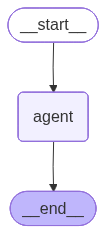

✅ 내장 PNG 기능으로 다이어그램 생성 완료

--- Running Workflow ---


> Entering new AgentExecutor chain...

Invoking: `get_workout_history` with `{'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752'}`


Found workout history for user 7356cf0e-19c2-4aef-982b-2607fdc00752: [{'id': 1, 'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752', 'created_at': '2025-09-18T06:13:24.108213+00:00', 'total_volume': 225, 'exercises': [{'name': '레그 익스텐션', 'reps': 15, 'rest': 60, 'sets': 3, 'weight': 5}]}, {'id': 2, 'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752', 'created_at': '2025-09-18T06:13:40.208091+00:00', 'total_volume': 125, 'exercises': [{'name': '레그 익스텐션', 'reps': 5, 'rest': 5, 'sets': 5, 'weight': 5}]}, {'id': 3, 'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752', 'created_at': '2025-09-18T06:14:59.66279+00:00', 'total_volume': 27, 'exercises': [{'name': '레그 익스텐션', 'reps': 3, 'rest': 3, 'sets': 3, 'weight': 3}]}, {'id': 4, 'user_id': '7356cf0e-19c2-4aef-982b-2607fdc00752', 'created_at': '2025-09-18T06:21:55.370

In [10]:
# 최종 권장 워크플로우 코드 (기존 코드 마지막 부분 교체)
from IPython.display import Image, display

# 7. 컴파일 및 시각화
app = workflow.compile()

print("--- Graph Mermaid Diagram (PNG) ---")
try:
    # LangGraph 내장 PNG 기능 시도
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ 내장 PNG 기능으로 다이어그램 생성 완료")
except Exception as e:
    print(f"내장 PNG 기능 사용 불가: {type(e).__name__}")
    print("텍스트 다이어그램으로 대체:")
    print(app.get_graph().draw_mermaid())

print("\n--- Running Workflow ---")
input_data = {
    "messages": [HumanMessage(content="What is my workout history? My user ID is '7356cf0e-19c2-4aef-982b-2607fdc00752'")]    
}
result = app.invoke(input_data)
print(result)